# Segmenting and Clustering Neighborhoods in Toronto

## To reproduce the report, all the data that was used, is in the github repository. Feel free to use this data.

In [561]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from sklearn import metrics
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


# 1. Download and Explore Dataset

#### Load and explore the data

In [42]:
path = r'data_ALL.xlsx'
neighborhoods_data = pd.read_excel(path, encoding = 'iso8859_5', sep ='|', skipinitialspace=True)
neighborhoods_data.head()

,Borough,Neighborhood,coordinates
0,schevchenkovskiy,"Данила Щербакивского, 52","50.470337, 30.406427"
1,schevchenkovskiy,"Жамбила Жабаева, 7д","50.467042, 30.431088"
2,schevchenkovskiy,"Перемоги, 76","50.458285, 30.425682"
3,schevchenkovskiy,"Парково-Сырецкая ул., 23","50.462484, 30.434798"
4,schevchenkovskiy,"Парково-Сырецкая ул., 19","50.463022, 30.436730"


In [43]:
neighborhoods_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 3 columns):
Borough         183 non-null object
Neighborhood    183 non-null object
coordinates     183 non-null object
dtypes: object(3)
memory usage: 4.4+ KB


#### As we can see, longitude and latitude are in the same column (coordinates, type: object ), so split  coordinates on latitude and longitude (and cast values to float dtype).

In [44]:
latitude = [] 
longitude = []
coordinates = neighborhoods_data['coordinates']
for coord in coordinates:
    tmp = coord.split(', ')
    latitude.append(float(tmp[0]))
    longitude.append(float(tmp[1]))
neighborhoods_data['Latitude'] = latitude
neighborhoods_data['Longitude'] = longitude

#### drop column 'coordinates'

In [45]:
neighborhoods_data.drop(['coordinates'],  axis= 1, inplace=True)
neighborhoods_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,schevchenkovskiy,"Данила Щербакивского, 52",50.470337,30.406427
1,schevchenkovskiy,"Жамбила Жабаева, 7д",50.467042,30.431088
2,schevchenkovskiy,"Перемоги, 76",50.458285,30.425682
3,schevchenkovskiy,"Парково-Сырецкая ул., 23",50.462484,30.434798
4,schevchenkovskiy,"Парково-Сырецкая ул., 19",50.463022,30.436730


#### explore "Borough"  values

In [46]:
neighborhoods_data["Borough"].value_counts()

darnitskiy          24
dneprovskyi         23
svjatoshinskiy      20
solomenskiy         20
goloseevskiy        19
podilskiy           16
schevchenkovskiy    16
pecherskiy          16
obolonskiy          16
desnjanskiy         13
Name: Borough, dtype: int64

In [47]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods_data['Borough'].unique()),
        neighborhoods_data.shape[0]
    )
)

The dataframe has 10 boroughs and 183 neighborhoods.


#### Use geopy library to get the latitude and longitude values of Kyiv.

In [48]:
address = 'Kyiv, UA'
geolocator = Nominatim(user_agent="n_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Kyiv are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Kyiv are 50.4500336, 30.5241361.


#### Create a map of Kyiv with neighborhoods superimposed on top.

In [539]:
# create map of Toronto using latitude and longitude values
map_kiev = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods_data['Latitude'], neighborhoods_data['Longitude'], neighborhoods_data['Borough'], neighborhoods_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_kiev)  
    
map_kiev

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

# 2. Explore Neighborhoods in Kyiv

#### Define Foursquare Credentials and Version

In [50]:
CLIENT_ID = 'your Foursquare ID' # your Foursquare ID
CLIENT_SECRET = 'your Foursquare Secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KD3YEP0OH5RUETOXJDWWMS4GAXQ1F0NMLGTMDAK00H3YKFT2
CLIENT_SECRET:GNGXDGWPBNR2VZDDWVN1FTVBZ335G1FDL5VJG5K5BUJQPPTS


#### Let's create a function to get all the neighborhoods venue data in Kyiv.

In [55]:
def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['distance'],
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id'],
            v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Distance',
                  'Venue Category',
                  'Category id',
                  'Venue id']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe.

In [56]:
kyiv_venues = getNearbyVenues(names=neighborhoods_data['Neighborhood'],
                                   latitudes=neighborhoods_data['Latitude'],
                                   longitudes=neighborhoods_data['Longitude']
                                  )

#### Let's check the size of the resulting dataframe

In [59]:
print(kyiv_venues.shape)
kyiv_venues.reset_index(drop=True, inplace=True)
kyiv_venues.head()

(4438, 10)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category,Category id,Venue id
0,"Данила Щербакивского, 52",50.470337,30.406427,Філіжанка Вольтера,50.471867,30.405154,192,Coffee Shop,4bf58dd8d48988d1e0931735,5576cbcb498e61f53880b1b8
1,"Данила Щербакивского, 52",50.470337,30.406427,МегаМаркет,50.473739,30.406419,378,Supermarket,52f2ab2ebcbc57f1066b8b46,5bf0561f31ac6c002c8fdb8d
2,"Данила Щербакивского, 52",50.470337,30.406427,Брускета,50.471044,30.406410,78,Italian Restaurant,4bf58dd8d48988d110941735,59f87c4492e7a93b9c7bf9ad
3,"Данила Щербакивского, 52",50.470337,30.406427,КиевЭкспоПлаза - Павильон Е,50.470473,30.403528,205,Public Art,507c8c4091d498d9fc8c67a9,5104381be4b0275f7240baf9
4,"Данила Щербакивского, 52",50.470337,30.406427,Сквер,50.470519,30.411015,325,Park,4bf58dd8d48988d163941735,4eae340d0aaf9e9a2471fa54


#### Take only the categories we need

##### we don’t need all the categories for our analysis, we only take the categories that we manually selected.
##### lets download selected category, and clean our venues

In [90]:
# download selected category id, and category weight
path = r'Category.xlsx'
df_cat = pd.read_excel(path, encoding = 'iso8859_5', sep ='|', skipinitialspace=True, index=False)
df_cat=df_cat.T
df_cat.reset_index(inplace = True, drop = True)
df_cat.columns = ['Category id', 'Category weight']
df_cat.head()

,Category id,Category weight
0,4bf58dd8d48988d1e5941735,10
1,52e81612bcbc57f1066b7a22,10
2,4bf58dd8d48988d175941735,2
3,4f4528bc4b90abdf24c9de85,2
4,56aa371be4b08b9a8d57355e,2


#### Add Category id and Category weight to kyiv_venues dataset.

In [67]:
df_merged = pd.merge(kyiv_venues, df_cat, on = 'Category id', how = "inner")

In [69]:
print(df_merged.shape)
df_merged.head()

(1813, 11)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category,Category id,Venue id,Category weight
0,"Данила Щербакивского, 52",50.470337,30.406427,Філіжанка Вольтера,50.471867,30.405154,192,Coffee Shop,4bf58dd8d48988d1e0931735,5576cbcb498e61f53880b1b8,5
1,"Данила Щербакивского, 52",50.470337,30.406427,Кофейня на Салютной,50.471932,30.405281,195,Coffee Shop,4bf58dd8d48988d1e0931735,4f5b4f9ae4b0a3bd22736a4f,5
2,"Данила Щербакивского, 52",50.470337,30.406427,Barista(expohall),50.470497,30.403254,225,Coffee Shop,4bf58dd8d48988d1e0931735,50996d91e4b0816f79219ed3,5
3,"Данила Щербакивского, 52",50.470337,30.406427,Want Coffee,50.471947,30.410503,339,Coffee Shop,4bf58dd8d48988d1e0931735,5b3ddb15db3aef0024ff124b,5
4,"Жамбила Жабаева, 7д",50.467042,30.431088,Класна кава,50.466012,30.429633,154,Coffee Shop,4bf58dd8d48988d1e0931735,58c2a420fbe8ff085cf4f239,5


In [70]:
kyiv_venues = df_merged

#### inspect Venue Category

Let's check how many venues were returned for each neighborhood

In [78]:
kyiv_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category,Category id,Venue id,Category weight
Neighborhood,,,,,,,,,,
"Академика Карпинского, 10",11,11,11,11,11,11,11,11,11,11
"Алма-Атинская, 37б",3,3,3,3,3,3,3,3,3,3
"Василия Липковского, 21",13,13,13,13,13,13,13,13,13,13
"Вінницька, 32",4,4,4,4,4,4,4,4,4,4
"Гоголівська, 11/39",25,25,25,25,25,25,25,25,25,25
"Григория Ващенко, 7",5,5,5,5,5,5,5,5,5,5
"Здолбуновская, 9Б",5,5,5,5,5,5,5,5,5,5
"Каховська, 60",3,3,3,3,3,3,3,3,3,3
"Сверстюка, 8,",15,15,15,15,15,15,15,15,15,15


#### Let's find out how many unique categories can be curated from all the returned venues

In [79]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 362 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

#### Using one hot encoding, transform venue.

In [210]:
# one hot encoding
kyiv_onehot = pd.get_dummies(kyiv_venues[['Venue Category']], prefix="", prefix_sep="")
#kyiv_onehot.drop("Neighborhood", axis = 1)
# add neighborhood column back to dataframe
kyiv_onehot['Neighborhood'] = kyiv_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [kyiv_onehot.columns[-1]] + list(kyiv_onehot.columns[:-1])
kyiv_onehot = kyiv_onehot[fixed_columns]

kyiv_onehot.tail()

,Neighborhood,Arcade,Art Museum,Athletics & Sports,Bakery,Beer Bar,Beer Garden,Big Box Store,Bookstore,Botanical Garden,Brewery,Bus Stop,Café,Candy Store,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cupcake Shop,Deli / Bodega,Dessert Shop,Dog Run,Doner Restaurant,Drugstore,Dry Cleaner,Food & Drink Shop,Forest,Grocery Store,Gym / Fitness Center,Gym Pool,Health Food Store,Historic Site,History Museum,Ice Cream Shop,Juice Bar,Lake,Liquor Store,Market,Metro Station,Movie Theater,Multiplex,Museum,Other Great Outdoors,Park,Pastry Shop,Pet Store,Pharmacy,Pizza Place,Planetarium,Pool,Pub,Public Art,Rest Area,Rock Club,Salon / Barbershop,School,Sculpture Garden,Shopping Mall,Snack Place,Tea Room,Theme Park,Theme Park Ride / Attraction,Tram Station,Veterinarian,Wine Bar,Zoo
1808,"Тургеневська, 43",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1809,"Голосеевский проспект, 99",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1810,"Тбіліський провулок, 10",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1811,"Богдана Гаврилишина, 6",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1812,"Тбіліський провулок, 3А",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


And let's examine the new dataframe size.

In [211]:
kyiv_onehot.shape

(1813, 67)

#### Next, let's group rows by neighborhood and by taking the max of occurrence of each category .

In [410]:
kyiv_grouped = kyiv_onehot.groupby('Neighborhood').max().reset_index()
print(kyiv_grouped.shape)
kyiv_grouped.head()

(179, 67)


,Neighborhood,Arcade,Art Museum,Athletics & Sports,Bakery,Beer Bar,Beer Garden,Big Box Store,Bookstore,Botanical Garden,Brewery,Bus Stop,Café,Candy Store,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cupcake Shop,Deli / Bodega,Dessert Shop,Dog Run,Doner Restaurant,Drugstore,Dry Cleaner,Food & Drink Shop,Forest,Grocery Store,Gym / Fitness Center,Gym Pool,Health Food Store,Historic Site,History Museum,Ice Cream Shop,Juice Bar,Lake,Liquor Store,Market,Metro Station,Movie Theater,Multiplex,Museum,Other Great Outdoors,Park,Pastry Shop,Pet Store,Pharmacy,Pizza Place,Planetarium,Pool,Pub,Public Art,Rest Area,Rock Club,Salon / Barbershop,School,Sculpture Garden,Shopping Mall,Snack Place,Tea Room,Theme Park,Theme Park Ride / Attraction,Tram Station,Veterinarian,Wine Bar,Zoo
0,"Академика Карпинского, 10",1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Алма-Атинская, 37б",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Василия Липковского, 21",1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Вінницька, 32",0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Гоголівська, 11/39",1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [266]:
kyiv_venues.sort_values('Venue Category', inplace=True)
kyiv_venues.reset_index(inplace=True, drop=True)
print(kyiv_venues.shape)

(1813, 11)


#### Set weight for each venue.

In [411]:
cat_weight = kyiv_venues.groupby('Venue Category').max().reset_index()
weight = cat_weight['Category weight'].tolist()
kyiv_grouped_drop = kyiv_grouped.drop('Neighborhood', 1)
res_kyiv_grouped = pd.DataFrame.multiply(kyiv_grouped_drop, weight) #kyiv_grouped.drop('Neighborhood', 1) * weight.T
res_kyiv_grouped['Neighborhood'] = kyiv_grouped['Neighborhood']
# move neighborhood column to the first column
fixed_columns = [res_kyiv_grouped.columns[-1]] + list(res_kyiv_grouped.columns[:-1])
res_kyiv_grouped = res_kyiv_grouped[fixed_columns]

kyiv_grouped = res_kyiv_grouped
kyiv_grouped.head()

,Neighborhood,Arcade,Art Museum,Athletics & Sports,Bakery,Beer Bar,Beer Garden,Big Box Store,Bookstore,Botanical Garden,Brewery,Bus Stop,Café,Candy Store,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cupcake Shop,Deli / Bodega,Dessert Shop,Dog Run,Doner Restaurant,Drugstore,Dry Cleaner,Food & Drink Shop,Forest,Grocery Store,Gym / Fitness Center,Gym Pool,Health Food Store,Historic Site,History Museum,Ice Cream Shop,Juice Bar,Lake,Liquor Store,Market,Metro Station,Movie Theater,Multiplex,Museum,Other Great Outdoors,Park,Pastry Shop,Pet Store,Pharmacy,Pizza Place,Planetarium,Pool,Pub,Public Art,Rest Area,Rock Club,Salon / Barbershop,School,Sculpture Garden,Shopping Mall,Snack Place,Tea Room,Theme Park,Theme Park Ride / Attraction,Tram Station,Veterinarian,Wine Bar,Zoo
0,"Академика Карпинского, 10",4,0,0,4,0,0,0,0,0,0,7,5,0,0,0,0,0,6,0,0,0,0,0,0,0,6,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,10,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Алма-Атинская, 37б",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Василия Липковского, 21",4,0,0,4,0,0,0,0,0,0,0,5,0,0,0,0,5,0,0,0,5,0,0,0,0,6,0,0,2,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,7,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Вінницька, 32",0,0,0,0,0,0,0,0,0,0,7,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Гоголівська, 11/39",4,0,0,4,0,0,0,5,0,1,0,5,0,0,0,5,5,0,0,0,0,0,0,0,0,0,0,0,2,0,0,7,0,6,0,0,0,0,0,0,0,0,0,10,0,0,0,3,0,0,5,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0


#### Normalize venue data by rows, (using sklearn.preprocessing.normalize).

In [270]:
kyiv_grouped_ = kyiv_grouped.drop('Neighborhood', 1)
X = kyiv_grouped_.values
Clus_dataSet = normalize(X, norm='l1', axis=1)
Clus_dataSet.shape
kyiv_grouped_[:] = Clus_dataSet
kyiv_grouped_['Neighborhood'] = kyiv_grouped['Neighborhood']
# move neighborhood column to the first column
fixed_columns = [kyiv_grouped_.columns[-1]] + list(kyiv_grouped_.columns[:-1])
kyiv_grouped_ = kyiv_grouped_[fixed_columns]

kyiv_grouped = kyiv_grouped_

kyiv_grouped

,Neighborhood,Arcade,Art Museum,Athletics & Sports,Bakery,Beer Bar,Beer Garden,Big Box Store,Bookstore,Botanical Garden,Brewery,Bus Stop,Café,Candy Store,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cupcake Shop,Deli / Bodega,Dessert Shop,Dog Run,Doner Restaurant,Drugstore,Dry Cleaner,Food & Drink Shop,Forest,Grocery Store,Gym / Fitness Center,Gym Pool,Health Food Store,Historic Site,History Museum,Ice Cream Shop,Juice Bar,Lake,Liquor Store,Market,Metro Station,Movie Theater,Multiplex,Museum,Other Great Outdoors,Park,Pastry Shop,Pet Store,Pharmacy,Pizza Place,Planetarium,Pool,Pub,Public Art,Rest Area,Rock Club,Salon / Barbershop,School,Sculpture Garden,Shopping Mall,Snack Place,Tea Room,Theme Park,Theme Park Ride / Attraction,Tram Station,Veterinarian,Wine Bar,Zoo
0,"Академика Карпинского, 10",0.065574,0.000000,0.000000,0.065574,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.114754,0.081967,0.000000,0.000000,0.000000,0.000000,0.000000,0.098361,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.098361,0.000000,0.000000,0.032787,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.163934,0.000000,0.163934,0.114754,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Алма-Атинская, 37б",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.416667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.583333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Василия Липковского, 21",0.086957,0.000000,0.000000,0.086957,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.108696,0.000000,0.000000,0.000000,0.000000,0.108696,0.000000,0.000000,0.000000,0.108696,0.000000,0.000000,0.000000,0.000000,0.130435,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.065217,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.152174,0.000000,0.000000,0.108696,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Вінницька, 32",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.218750,0.156250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.312500,0.000000,0.312500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,"Гоголівська, 11/39",0.058824,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.073529,0.00000,0.014706,0.000000,0.073529,0.000000,0.000000,0.000000,0.073529,0.073529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,0.000000,0.102941,0.000000,0.088235,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.147059,0.000000,0.000000,0.000000,0.044118,0.000000,0.000000,0.073529,0.000000,0.000000,0.000000,0.088235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Григория Ващенко, 7",0.000000,0.000000,0.000000,0.153846,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [294]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [306]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most significant Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most significant Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kyiv_grouped['Neighborhood']

for ind in np.arange(kyiv_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kyiv_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most significant Venue,2nd Most significant Venue,3rd Most significant Venue,4th Most significant Venue,5th Most significant Venue
0,"Академика Карпинского, 10",Pet Store,Park,Pharmacy,Bus Stop,Convenience Store
1,"Алма-Атинская, 37б",Pharmacy,Coffee Shop,Zoo,Gym Pool,Gym / Fitness Center
2,"Василия Липковского, 21",Pharmacy,Food & Drink Shop,Coffee Shop,Pool,Dessert Shop
3,"Вінницька, 32",Pet Store,Park,Bus Stop,Café,Zoo
4,"Гоголівська, 11/39",Park,Historic Site,Salon / Barbershop,Ice Cream Shop,Coffee Shop


<a id='item4'></a>

## 4. Cluster Neighborhoods

#### find number of clusters

(179, 66)


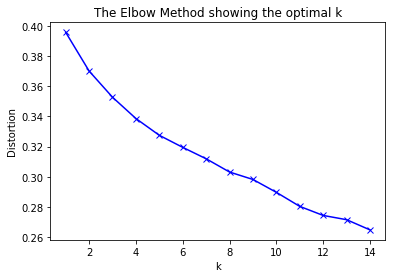

In [307]:
kyiv_grouped_clustering = kyiv_grouped.drop('Neighborhood', 1)

print(kyiv_grouped_clustering.shape)
# k means determine k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(kyiv_grouped_clustering)
    kmeanModel.fit(kyiv_grouped_clustering)
    distortions.append(sum(np.min(cdist(kyiv_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / kyiv_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Run *k*-means to cluster the neighborhood into 5 clusters.

In [747]:
# set number of clusters
kclusters = 8

kyiv_grouped_clustering = kyiv_grouped.drop('Neighborhood', 1)

#toronto_grouped_clustering
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, n_init=10).fit(kyiv_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 4, 4, 0, 1, 6, 4, 1, 4, 5])

Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

In [748]:
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most significant Venue,2nd Most significant Venue,3rd Most significant Venue,4th Most significant Venue,5th Most significant Venue
0,0,"Академика Карпинского, 10",Pet Store,Park,Pharmacy,Bus Stop,Convenience Store
1,4,"Алма-Атинская, 37б",Pharmacy,Coffee Shop,Zoo,Gym Pool,Gym / Fitness Center
2,4,"Василия Липковского, 21",Pharmacy,Food & Drink Shop,Coffee Shop,Pool,Dessert Shop
3,0,"Вінницька, 32",Pet Store,Park,Bus Stop,Café,Zoo
4,1,"Гоголівська, 11/39",Park,Historic Site,Salon / Barbershop,Ice Cream Shop,Coffee Shop


In [749]:
# add clustering labels

try:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except:
    neighborhoods_venues_sorted.drop("Cluster Labels", axis = 1, inplace=True)
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kyiv_merged = neighborhoods_data

# merge kyiv_grouped with kyiv_data to add latitude/longitude for each neighborhood
kyiv_merged = kyiv_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

kyiv_merged
kyiv_merged.dropna(inplace=True)
kyiv_merged.shape

(180, 10)

#### specific crime per 1000 population in Kyiv districts

In [750]:
dict_dist = {'Borough': ['darnitskiy', 'desnjanskiy', 'dneprovskyi', 'goloseevskiy',
                         'obolonskiy', 'pecherskiy', 'podilskiy', 'schevchenkovskiy',
                         'solomenskiy', 'svjatoshinskiy'],
             'Count':[12.17812573, 15.28347018, 17.59714333, 13.29399061,
                      10.18970699, 8.781640188, 6.582038155, 20.30417838,
                      10.67646848, 7.048115878],
             'id':["1754757", "1754820", "1754781", "1754513", "1754928",
                   "1755013", "1754975", "1755014", "1754514", "1754751"]}
district = pd.DataFrame(dict_dist)
district

,Borough,Count,id
0,darnitskiy,12.178126,1754757
1,desnjanskiy,15.283470,1754820
2,dneprovskyi,17.597143,1754781
3,goloseevskiy,13.293991,1754513
4,obolonskiy,10.189707,1754928
5,pecherskiy,8.781640,1755013
6,podilskiy,6.582038,1754975
7,schevchenkovskiy,20.304178,1755014
8,solomenskiy,10.676468,1754514
9,svjatoshinskiy,7.048116,1754751


In [751]:
bins = np.linspace(min(district["Count"]), max(district["Count"]), 4)
bins

array([ 6.58203816, 11.1560849 , 15.73013164, 20.30417838])

In [752]:
group_names = ['Low', 'Medium', 'High']

In [753]:
district['Crime_rating'] = pd.cut(district['Count'], bins, labels=group_names, include_lowest=True )
district

,Borough,Count,id,Crime_rating
0,darnitskiy,12.178126,1754757,Medium
1,desnjanskiy,15.283470,1754820,Medium
2,dneprovskyi,17.597143,1754781,High
3,goloseevskiy,13.293991,1754513,Medium
4,obolonskiy,10.189707,1754928,Low
5,pecherskiy,8.781640,1755013,Low
6,podilskiy,6.582038,1754975,Low
7,schevchenkovskiy,20.304178,1755014,High
8,solomenskiy,10.676468,1754514,Low
9,svjatoshinskiy,7.048116,1754751,Low


In [754]:
kyiv_merged_crime = pd.merge(kyiv_merged, district[['Borough', 'Crime_rating']],
                       on = 'Borough', how = "inner")
kyiv_merged_crime.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most significant Venue,2nd Most significant Venue,3rd Most significant Venue,4th Most significant Venue,5th Most significant Venue,Crime_rating
0,schevchenkovskiy,"Данила Щербакивского, 52",50.470337,30.406427,1.0,Park,Public Art,Coffee Shop,Café,Zoo,High
1,schevchenkovskiy,"Жамбила Жабаева, 7д",50.467042,30.431088,1.0,Park,Food & Drink Shop,Coffee Shop,Café,Bakery,High
2,schevchenkovskiy,"Перемоги, 76",50.458285,30.425682,5.0,Metro Station,Bus Stop,Pharmacy,Convenience Store,Café,High
3,schevchenkovskiy,"Парково-Сырецкая ул., 23",50.462484,30.434798,1.0,Park,Bus Stop,Coffee Shop,Café,Snack Place,High
4,schevchenkovskiy,"Парково-Сырецкая ул., 19",50.463022,30.436730,1.0,Park,Café,Coffee Shop,Snack Place,Zoo,High


#### Finally, let's visualize the resulting clusters

In [796]:
world_map = folium.Map(location=[50.4500336, 30.5241361], zoom_start=11)
world_geo = r'Kyiv_AL7.GeoJson' # geojson file

In [756]:
# create map

world_map.choropleth(
    geo_data=world_geo,
    data=district,
    columns=['id', 'Count'],
    key_on='feature.properties.id',
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.6,
    legend_name='Crime rate in Kyiv'
)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kyiv_merged['Latitude'], kyiv_merged['Longitude'], kyiv_merged['Neighborhood'], kyiv_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(world_map)
world_map

D:\Python\Python36\Lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


<a id='item5'></a>

## 5. Examine Clusters

#### Now, examine each cluster and determine the discriminating venue categories that distinguish each cluster.

#### Examine neighborhood for which the criminal rating is low.

In [794]:
kyiv_crime_low = kyiv_merged_crime[kyiv_merged_crime['Crime_rating'] == 'Low']

#### function for plot clusters venue 

In [776]:
def plot_cluster(cluster_data):
    values = cluster[['1st Most significant Venue', '2nd Most significant Venue', '3rd Most significant Venue']].values
    unique, counts = np.unique(values, return_counts=True)
    df_val_count = pd.DataFrame(np.asarray((unique, counts)).T)
    df_val_count.rename(columns={0: "venue", 1: "count"}, inplace=True)
    df_val_count.set_index(df_val_count['venue'], drop = True, inplace=True)
    df_val_count.drop( labels=['venue'],axis=1, inplace=True)
    n=4
    if unique.shape[0] > 7:
        n=6
    elif unique.shape[0] <= 6:
        n=3
    df_val_count.plot(kind='barh', figsize=(5, n), color='steelblue')
    plt.xlabel('Count')
    plt.title('sum 1st, 2nd, and 3rd \'Most significant Venue\' ')
    for index, value in enumerate(df_val_count): 
        label = value
    plt.show()

#### Cluster 0

(11, 8)


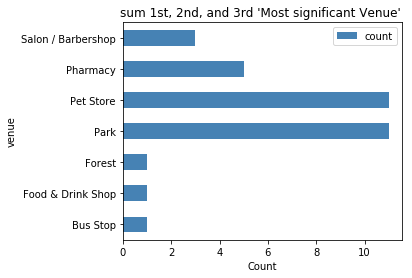

In [777]:
cluster = kyiv_crime_low.loc[kyiv_merged_crime['Cluster Labels'] == 0, 
                               kyiv_crime_low.columns[[0]+[1] + list(range(5, kyiv_crime_low.shape[1]))]]
print(cluster.shape)
plot_cluster(cluster)

#### Cluster 1

(23, 8)


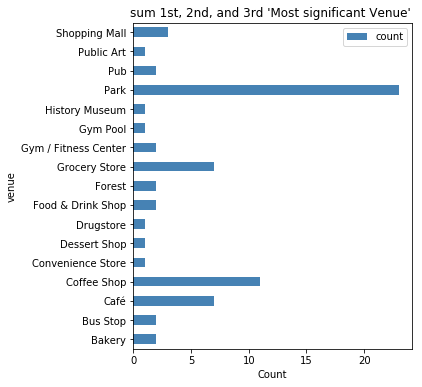

In [778]:
cluster = kyiv_crime_low.loc[kyiv_merged_crime['Cluster Labels'] == 1, 
                               kyiv_crime_low.columns[[0]+[1] + list(range(5, kyiv_crime_low.shape[1]))]]
print(cluster.shape)
plot_cluster(cluster)

#### Cluster 2

(6, 8)


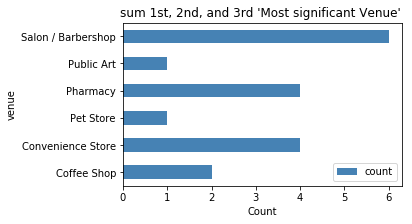

In [779]:
cluster = kyiv_crime_low.loc[kyiv_merged_crime['Cluster Labels'] == 2, 
                               kyiv_crime_low.columns[[0]+[1] + list(range(5, kyiv_crime_low.shape[1]))]]
print(cluster.shape)
plot_cluster(cluster)

#### Cluster 3

(2, 8)


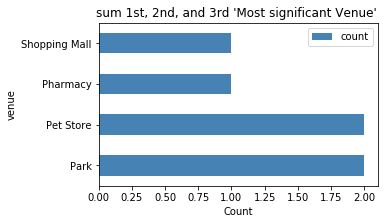

In [780]:
cluster = kyiv_crime_low.loc[kyiv_merged_crime['Cluster Labels'] == 3, 
                               kyiv_crime_low.columns[[0]+[1] + list(range(5, kyiv_crime_low.shape[1]))]]
print(cluster.shape)
plot_cluster(cluster)

#### Cluster 4

(8, 8)


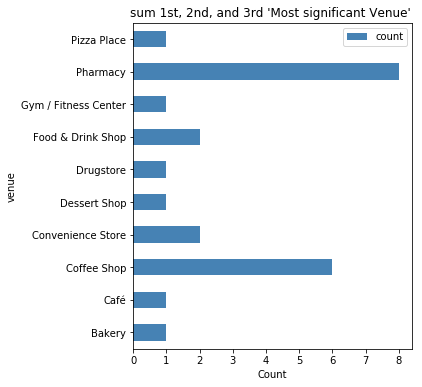

In [781]:
cluster = kyiv_crime_low.loc[kyiv_merged_crime['Cluster Labels'] == 4, 
                               kyiv_crime_low.columns[[0]+[1] + list(range(5, kyiv_crime_low.shape[1]))]]
print(cluster.shape)
plot_cluster(cluster)

#### Cluster 5

(3, 8)


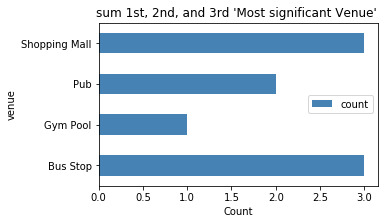

In [782]:
cluster = kyiv_crime_low.loc[kyiv_merged_crime['Cluster Labels'] == 5, 
                               kyiv_crime_low.columns[[0]+[1] + list(range(5, kyiv_crime_low.shape[1]))]]
print(cluster.shape)
plot_cluster(cluster)

#### Cluster 6

(12, 8)


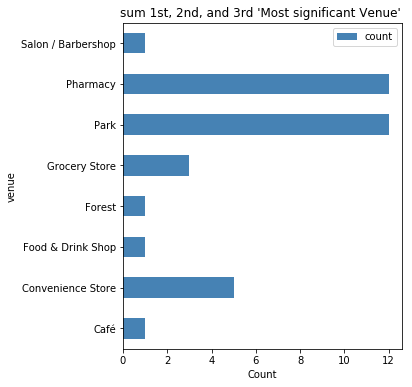

In [783]:
cluster = kyiv_crime_low.loc[kyiv_merged_crime['Cluster Labels'] == 6, 
                               kyiv_crime_low.columns[[0]+[1] + list(range(5, kyiv_crime_low.shape[1]))]]
print(cluster.shape)
plot_cluster(cluster)

#### Cluster 7

(21, 8)


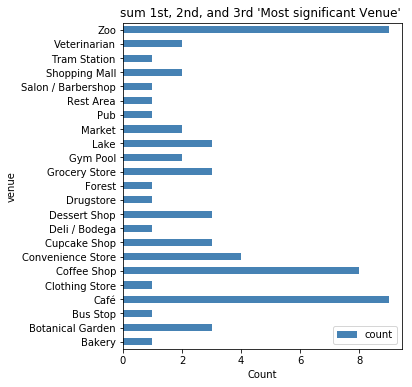

In [784]:
cluster = kyiv_crime_low.loc[kyiv_merged_crime['Cluster Labels'] == 7, 
                               kyiv_crime_low.columns[[0]+[1] + list(range(5, kyiv_crime_low.shape[1]))]]
print(cluster.shape)
plot_cluster(cluster)

#### In our opinion, the best clusters are: 0, 1, 3 and 5, lets plot map with selected cluster.

In [789]:
selected_cluster_data = kyiv_crime_low[kyiv_crime_low['Cluster Labels'].isin([0,1,3,5])]
selected_cluster_data.shape

(39, 11)

In [795]:
world_map = folium.Map(location=[50.4500336, 30.5241361], zoom_start=11)
world_geo = r'Kyiv_AL7.GeoJson' # geojson file

In [792]:
# create map

world_map.choropleth(
    geo_data=world_geo,
    data=district,
    columns=['id', 'Count'],
    key_on='feature.properties.id',
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.6,
    legend_name='Crime rate in Kyiv'
)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(selected_cluster_data['Latitude'], selected_cluster_data['Longitude'], selected_cluster_data['Neighborhood'], selected_cluster_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(world_map)
world_map